# OCOM510M Data Science: Assessment 2

Student ID: 202031023

## 1. Aims, objectives and plan
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words. 100-200 words.

Please demonstrate how you have conducted the project with a simple Gantt chart.

## 2. Understanding the case study

    ###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the client's needs. (You can include more than four points.) 200-300 words.

1.
1. 
1. 
1. 



## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- ~~Merging, pivoting and melting, if necessary~~
- ~~Preparing the labels appropriately, if necessary~~
- ~~Dealing with missing values (imputation, filtering) without leaking, if necessary~~
- ~~Dealing with duplicate values, if necessary~~
- Scaling, without leaking, if necessary
- ~~Dealing with correlation and collinearity, if necessary~~
- ~~Variance analysis, if necessary~~
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
~~ Identifying and dealing with class imbalance, if necessary~~
~~- Identifying and dealing with outliers, if necessary~~
- Categorical and numerical encoding if necessary
- Other pre-processing

#### 3.1 Imports
Importing allowed libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


#### 3.2 Load data sets
Loading data sets raw and verify how they look like.


In [3]:
# 1. load datasets
data_dir = 'TrainData/'
demographics = pd.read_csv(data_dir + 'Train_Demographics.csv')
claim = pd.read_csv(data_dir + 'Train_Claim.csv')
policy = pd.read_csv(data_dir + 'Train_Policy.csv')
vehicle = pd.read_csv(data_dir + 'Train_Vehicle.csv')
target = pd.read_csv(data_dir + 'Traindata_with_Target.csv')

# Trainingdata_without_Target.xlsx is skipped, using Traindata_with_Target.csv with target column
# test_target = pd.read_excel(data_dir + 'Traindata_without_Target.xlsx', sheet_name=1)

display(Markdown("### Demographics"))
display(demographics.head())

display(Markdown("### Claim"))
display(claim.head())

display(Markdown("### Policy"))
display(policy.head())

display(Markdown("### Vehicle"))
display(vehicle.head())

display(Markdown("### Target"))
display(target.head())

### Demographics

,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


### Claim

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


### Policy

,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


### Vehicle

,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


### Target

,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


At first glance the output shows that dataset vehicle contains considerable more rows and needs to be reworked. All other csv files seem to have consistent rows. But first an analysis on missing values will be performed.

#### 3.3 Dealing with missing values
Based on AttributeInformation.pdf there is a set of custom missing values which need to be observed. The findings in this step are:
- AttributeInformation.pdf is inconsistent with the real missing values in the file.
- Predefined missing values e.g. -1, -5 could be used in other features as meaningful values within the same DataFrame and therefore could be selected as missing values although they are not. This is not the case.
- Pandas loads by default "NA" as NaN.
- Due to anonymization not all features are listed, e.g. TotalCharges is not present in the csv file.
- Country contains NaN values

Check missing values in datasets and check if other columns other than the ones specified in AttributeInformation have any of the pre-defined missing values.

In [4]:
# Train_Policy.csv
cols_with_minus_one = (policy == -1).sum().sort_values(ascending=False)
cols_with_minus_one[cols_with_minus_one > 0]

PolicyAnnualPremium    141
dtype: int64

In [5]:
# Train_Policy.csv

# TotalCharges feature is not present in Train_Policy.csv despite it is described AttributeInformation.pdf
cols_with_MISSINGVAL = (policy == "MISSINGVAL").sum()
cols_with_MISSINGVAL[cols_with_MISSINGVAL > 0]

Series([], dtype: int64)

In [6]:
# Train_Demographics.csv
na_counts = demographics.isna().sum()
na_counts[na_counts > 0]

InsuredGender    30
Country           2
dtype: int64

In [7]:
# Train_Claim.csv
claim_with_minus_five = (claim == -5).sum()
claim_with_minus_five[claim_with_minus_five > 0]

IncidentTime    31
dtype: int64

In [8]:
# Train_Claim.csv
claim_with_MISSINGVALUE = (claim == 'MISSINGVALUE').sum()
claim_with_MISSINGVALUE[claim_with_MISSINGVALUE > 0]

Witnesses    46
dtype: int64

In [9]:
# Train_Claim.csv
claim_with_MISSEDDATA = (claim == 'MISSEDDATA').sum()
claim_with_MISSEDDATA[claim_with_MISSEDDATA > 0]

AmountOfTotalClaim    50
dtype: int64

In [10]:
# Train_Claim.csv
claim_with_qmarks = (claim == "?").sum()
claim_with_qmarks[claim_with_qmarks > 0]

TypeOfCollission     5162
PropertyDamage      10459
PoliceReport         9805
dtype: int64

In [11]:
# Train_Vehicle.csv
vehicle_with_missing_vals = (vehicle == "???").sum()
vehicle_with_missing_vals[vehicle_with_missing_vals > 0]

VehicleAttributeDetails    50
dtype: int64

In the next step I pass the `na_values` specific per dataset when loading the csv. I explicitly intend to avoid passing a python list of missing values, this in order to prevent accidental corruption by marking actual e.g. -1 or -5 values as missing values in other datasets or even in the same dataset but in different features (in the cells above it was checked that current dataset does not contain values marked as missing values in other features with meaning intent). So I opted to pass the specific missing value token per dataset only.

In [12]:
# Reload datasets and correct for missing values as per AttributeInformation.pdf definition
demographics = pd.read_csv(data_dir + 'Train_Demographics.csv', na_values=['NA']) # NA was automatically converted by Pandas however for illustration purposes
claim = pd.read_csv(data_dir + 'Train_Claim.csv', na_values=['?','-5', 'MISSINGVALUE', 'MISSEDDATA'])
policy = pd.read_csv(data_dir + 'Train_Policy.csv', na_values=['NA', '-1', 'MISSINGVAL'])
vehicle_raw = pd.read_csv(data_dir + 'Train_Vehicle.csv', na_values=['???'])

# Check if missing values were marked as NaN.
policy_na = policy.isna().sum()
policy_na = policy_na[policy_na > 0]
print(policy_na.to_string())

demographics_na = demographics.isna().sum()
demographics_na = demographics_na[demographics_na > 0]
print(demographics_na.to_string())

claim_na = claim.isna().sum()
claim_na = claim_na[claim_na > 0]
print(claim_na.to_string())

vehicle_na = vehicle_raw.isna().sum()
vehicle_na = vehicle_na[vehicle_na > 0]
print(vehicle_na.to_string())


PolicyAnnualPremium    141
InsuredGender    30
Country           2
TypeOfCollission         5162
AuthoritiesContacted     2692
IncidentTime               31
PropertyDamage          10459
Witnesses                  46
PoliceReport             9805
AmountOfTotalClaim         50
VehicleAttributeDetails    50


#### 3.4 Pivoting and Merging
In Section 3.2, during data loading, one of the findings was that the dataset T`rain_Vehicle.csv` required restructuring. The vehicle data is stored in an attribute–value pair format. To ensure that each customer is represented by a single row with separate columns for attributes such as VehicleID and VehicleModel, the dataset is converted from long format to wide format, a process commonly referred to as pivoting.

In [13]:
# Understand which attributes exist in dataset vehicle
vehicle_raw.VehicleAttribute.unique()
## 4 different attributes

array(['VehicleID', 'VehicleModel', 'VehicleMake', 'VehicleYOM'],
      dtype=object)

In [14]:
# Pivot the vehicle data from long to wide format to reflect previous attributes
vehicle = vehicle_raw.pivot(
    index='CustomerID',
    columns='VehicleAttribute',
    values='VehicleAttributeDetails'
).reset_index()

vehicle.columns.name = None
# Check the shape of the new dataset
print("Vehicle Shape:", vehicle.shape)
vehicle.head()

Vehicle Shape: (28836, 5)


,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999
3,Cust10003,Vehicle37363,Volkswagen,Jetta,2003
4,Cust10004,Vehicle28633,Toyota,CRV,2010


Next, is time to consolidate all datasets by merging into one single dataframe. This dataframe will later be reworked to select relevant features for model fitting. I have implemented an `audit_merge` helper function to verify that the CustomerID keys match across all files before merging. In this specific use case, the target and source datasets are synchronized, however, this audit step was important for identifying potential data gaps. By using an Inner Join strategy, I ensure that the final dataset only contains records with a complete set of features from all four source files.

In [15]:
# Check that there are no data gaps between target and source datasets.
# For this Case Study there are non and all CustomerID keys match accrross files.
# For simplicity this function is invoked once.
def audit_merge(target_df, source_df):
    target_ids = set(target_df['CustomerID'])
    source_ids = set(source_df['CustomerID'])

    # 1. IDs in target_df but MISSING in source_df
    missing_in_demo = target_ids - source_ids

    # 2. IDs in source_df but MISSING in target_df
    missing_in_target = source_ids - target_ids

    # 3. The Intersection (IDs that exist in both)
    common_ids = target_ids.intersection(source_ids)
    print("---- Audit analysis ----")
    print(f"IDs in Target: {len(target_ids)}")
    print(f"IDs in Source: {len(source_ids)}")
    print(f"Common IDs: {len(common_ids)}")
    print(f"Missing in Source: {len(missing_in_demo)}")
    print(f"Missing in Target: {len(missing_in_target)}")
    print()

In [16]:
# Perform merges sequentially

# Start with the Target dataset
data_merged = target.copy()

# Merge with Demographics
audit_merge(data_merged, demographics) # invoking once to avoid clutter. However, this operation was checked in upcoming merges leading to no gaps.
data_merged = data_merged.merge(demographics, on='CustomerID', how='inner')

# Merge with Policy
data_merged = data_merged.merge(policy, on='CustomerID', how='inner')

# Merge with Claim data
data_merged = data_merged.merge(claim, on='CustomerID', how='inner')

# 4. Merge with the Pivoted Vehicle data
data_merged = data_merged.merge(vehicle, on='CustomerID', how='inner')

# Check the first version datamerged rows and column
print("---- Data merged ----")
display(data_merged.head())

---- Audit analysis ----
IDs in Target: 28836
IDs in Source: 28836
Common IDs: 28836
Missing in Source: 0
Missing in Target: 0

---- Data merged ----


,CustomerID,ReportedFraud,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,...,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust20065,N,58,471784,MALE,JD,sales,video-games,0,-42700,...,1.0,NaN,43973.0,9396,4698,29879,Vehicle30662,Mercedes,E400,2005
1,Cust37589,N,34,431937,FEMALE,High School,transport-moving,polo,51300,0,...,1.0,YES,62310.0,6539,6539,49232,Vehicle17183,Toyota,Highlander,2010
2,Cust24312,N,52,479320,FEMALE,PhD,machine-op-inspct,exercise,0,0,...,0.0,NaN,42824.0,6069,6069,30686,Vehicle33982,Volkswagen,Passat,2002
3,Cust5493,Y,25,607763,FEMALE,College,exec-managerial,exercise,47400,-56100,...,0.0,NaN,45672.0,253,5741,39678,Vehicle12299,Toyota,Highlander,2011
4,Cust7704,Y,27,441783,MALE,Masters,sales,chess,0,0,...,2.0,NO,81472.0,7407,14813,59252,Vehicle30447,Ford,Wrangler,2010


#### 3.5 Preparing the labels

In [17]:
# Convert 'ReportedFraud' (Target) to 1 (Fraud) and 0 (Non-Fraud)
data_merged['ReportedFraud_Numeric'] = data_merged['ReportedFraud'].map({'Y': 1, 'N': 0})

# Drop the original 'ReportedFraud' column
data_merged.drop('ReportedFraud', axis=1, inplace=True)

#### 3.6 Data Type conversion
Inspect `dtypes` of the newly created data_merged:

In [18]:
print(data_merged.dtypes.to_string())

CustomerID                     object
InsuredAge                      int64
InsuredZipCode                  int64
InsuredGender                  object
InsuredEducationLevel          object
InsuredOccupation              object
InsuredHobbies                 object
CapitalGains                    int64
CapitalLoss                     int64
Country                        object
InsurancePolicyNumber           int64
CustomerLoyaltyPeriod           int64
DateOfPolicyCoverage           object
InsurancePolicyState           object
Policy_CombinedSingleLimit     object
Policy_Deductible               int64
PolicyAnnualPremium           float64
UmbrellaLimit                   int64
InsuredRelationship            object
DateOfIncident                 object
TypeOfIncident                 object
TypeOfCollission               object
SeverityOfIncident             object
AuthoritiesContacted           object
IncidentState                  object
IncidentCity                   object
IncidentAddr

There are a few data types which do not match their intention and therefore will be converted to a more meaningful type.
| Feature Category | Transformation | Justification |
| :--- | :--- | :--- |
| **DateOfPolicyCoverage** | `Object` → `Datetime` | Converted to date format for initial inspection; dropped during training as raw dates are non-numeric. |
| **DateOfIncident** | `Object` → `Datetime` | Converted to date format; excluded from the model to prevent temporal overfitting on specific dates. |
| **VehicleYOM** | `Object` → `Int64` | Cast as an integer to represent the vehicle's age; treated as a numeric feature for the model. |

Worth to mention that although there are no half witnesses, Pandas upcast to float if it contains missing values like in this case, so it remains as `float64`. So for the time being the only type to change is `VehicleYOM`

In [19]:
# Inspect unique values of VehicleYOM
data_merged["VehicleYOM"].unique()

array(['2005', '2010', '2002', '2011', '2009', '2006', '2013', '1999',
       '2008', '2000', '2004', '2001', '1995', '2015', '2007', '1998',
       '2003', '2012', '2014', '1997', '1996'], dtype=object)

In [20]:
# convert to numeric
data_merged["VehicleYOM"] = pd.to_numeric(data_merged["VehicleYOM"], errors="coerce")
data_merged["VehicleYOM"].dtype

dtype('int64')

#### 3.7 Dealing with duplicates
No duplicates were found, therefore after `drop_duplicates` dataframe length remain equal

In [21]:
print('data_merge' , data_merged.shape)
data_merged.drop_duplicates(inplace=True)
print('data_merge after dropping duplicates' , data_merged.shape)

data_merge (28836, 42)
data_merge after dropping duplicates (28836, 42)


#### 3.8 Removing noisy attributes
To improve model generalization and reduce overfitting, the following attributes were removed:

| Feature Category | Description                                                                       |
| :--- |:----------------------------------------------------------------------------------|
| **CustomerID** | Unique random ID; has no predictive relationship with fraud likelihood           |
| **InsurancePolicyNumber** | Unique administrative key; provides no statistical patterns for learning         |
| **InsuredZipCode** | ~1000 unique codes; introduces excessive noise and leads to overfitting          |
| **IncidentAddress** | Specific text data; offers no generalizable patterns for fraud detection         |
| **VehicleID** | Random identifier; specific to a single unit and not relevant for trend analysis |
| **Country** | Constant value, with zero Variance provides no useful information to the model |
| **DateOfPolicyCoverage** | Datetime objects cannot be processed directly by classification models           |
| **DateOfIncident** | Raw datetime objects create noise and risk timing specific past events         |
| **VehicleModel** | **VehicleMake** is used instead to provide a more generalized, robust feature    |



In [22]:
# Columns to drop
cols_to_drop = [
    'CustomerID', 'InsurancePolicyNumber', 'InsuredZipCode',
    'IncidentAddress', 'VehicleID', 'Country',
    'DateOfPolicyCoverage', 'DateOfIncident', 'VehicleModel'
]

# Separate features and target
X = data_merged.drop(columns=cols_to_drop + ['ReportedFraud_Numeric'])
y = data_merged['ReportedFraud_Numeric']

# Categorize for the Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Total features retained for Pipeline: {len(X.columns)}")

Total features retained for Pipeline: 32


#### 3.9 Colinearity
A correlation analysis was performed on all numerical attributes. As the matrix depicts, high levels of correlation are found in the bottom-right corner since the total claim is just the sum of the others, `AmountOfTotalClaim` is redundant information.

`CustomerLoyaltyPeriod` and `InsuredAge` is expected, older customers have had more loyalty years, but it is not seen as a redundancy factor.

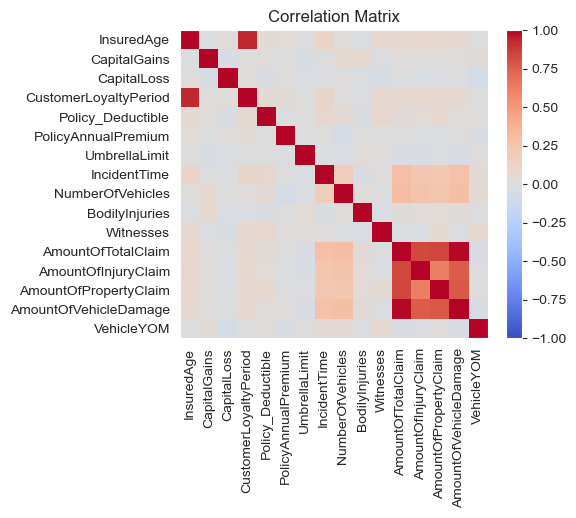

In [23]:
# Compute correlation (Check for multicollinearity)
corr = X.select_dtypes('number').corr()

plt.figure(figsize=(6, 4))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

plt.gca().set_aspect('equal')
plt.grid(False)

plt.colorbar(fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.title("Correlation Matrix")
plt.show()

In [24]:
# Dropping AmountOfTotalClaim
redundant_features = ['AmountOfTotalClaim']

# Drop them from X variable
X = X.drop(columns=redundant_features)
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
print(f"Total features retained for Pipeline: {len(X.columns)}")

Total features retained for Pipeline: 31


#### 3.10. Target Variable Analysis: Class Imbalance

A critical step in insurance fraud detection is assessing the distribution of the target variable `ReportedFraud_Numeric`. As Fraud is normally a minority occurrence, which creates a "Class Imbalance" problem.

**Observations:**
* The dataset is imbalanced with nearly 3 times more genuine claims than fraudulent ones
* To prevent the model from ignoring the minority class, **Cost-Sensitive Learning** was implemented by using the `class_weight='balanced'` parameter. This penalizes the model more heavily for missing a fraud case than for misclassifying a genuine one.

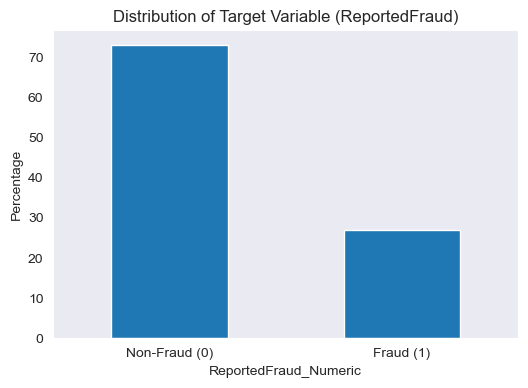

In [25]:
# Check for class imbalance
imbalance_check = data_merged['ReportedFraud_Numeric'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 4))
imbalance_check.plot(kind='bar')
plt.title('Distribution of Target Variable (ReportedFraud)')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.grid(False)
plt.ylabel('Percentage')
plt.show()

#### 3.11 Dealing with outliers
To satisfy the requirement of identifying outliers based on extreme probability thresholds, the following logic was applied. Any data point falling below the **5th percentile** or above the **95th percentile** is classified as an outlier.

In [26]:
outlier_report = []

for col in numeric_features: # Reusing your existing variable
    # Define bounds using 5th and 95th percentiles
    lower_bound = data_merged[col].quantile(0.05)
    upper_bound = data_merged[col].quantile(0.95)

    # Identify outliers
    outliers = data_merged[(data_merged[col] < lower_bound) | (data_merged[col] > upper_bound)]

    outlier_report.append({
        'Feature': col,
        'Outlier Count': len(outliers),
        'Percentage': f"{(len(outliers) / len(data_merged) * 100):.2f}%",
        '5th Percentile': lower_bound,
        '95th Percentile': upper_bound,
        'Min Outlier': outliers[col].min() if not outliers.empty else 'N/A',
        'Max Outlier': outliers[col].max() if not outliers.empty else 'N/A'
    })

# Display the report
df_percentile_outliers = pd.DataFrame(outlier_report).sort_values(by='Outlier Count', ascending=False)
display(df_percentile_outliers)

,Feature,Outlier Count,Percentage,5th Percentile,95th Percentile,Min Outlier,Max Outlier
13,AmountOfVehicleDamage,2883,10.00%,3292.000,59936.500,109,79560
12,AmountOfPropertyClaim,2879,9.98%,548.000,14672.000,0,23670
11,AmountOfInjuryClaim,2878,9.98%,546.000,14720.750,0,21450
5,PolicyAnnualPremium,2870,9.95%,922.613,1591.232,436.28,2047.59
3,CustomerLoyaltyPeriod,2834,9.83%,53.000,395.000,1,479
14,VehicleYOM,2723,9.44%,1997.000,2013.000,1995,2015
7,IncidentTime,2374,8.23%,2.000,21.000,0.0,23.0
0,InsuredAge,2360,8.18%,27.000,54.000,19,64
6,UmbrellaLimit,1476,5.12%,0.000,5928631.500,-1000000,10000000
1,CapitalGains,1419,4.92%,0.000,70500.000,70600,100500


The percentile audit reveals three distinct categories of extreme values within the feature set

| Action Zone | Features | Percentile Finding | Final Strategy     | Logic & Justification                                                                                      |
| :--- | :--- | :--- |:-------------------|:-----------------------------------------------------------------------------------------------------------|
| **Logic Error** | `UmbrellaLimit` | 5.12% Outliers (Min: -1M) | **Convert to NaN** | Corrects impossible negative data entry errors while preserving the 10M high-liability risk signal.        |
| **High-Risk Signal** | `VehicleDamage`, `InjuryClaim`, `PropertyClaim` | ~10.0% Outliers (Max: $79k) | **Retain & Scale** | High-severity claims are primary fraud indicators. Removing these would delete the "motive" for the fraud. |
| **Natural Tails** | `InsuredAge`, `CapitalGains`, `VehicleYOM` | 4.8% - 9.4% Outliers | **Retain & Scale** | Reflects the diverse variety of customers in the dataset; these values are extreme but logically valid.    |
| **Clean / Discrete** | `Witnesses`, `BodilyInjuries`, `Deductible` | 0.0% Outliers | **No Action**      | No observations fall outside the 5th-95th percentile limits.                                               |

Because significant financial outliers were **retained** to capture fraud signals, **`RobustScaler`** has been implemented in the preprocessing pipeline. This ensures that extreme ~79,000 vehicle damage claims provide useful information to the model without overwhelming or distorting the coefficients for the rest of the dataset. The following function will be invoked during pipeline creation.

In [27]:
# Filter the dataframe for negative Umbrella Limits
negative_umbrella = data_merged[data_merged['UmbrellaLimit'] < 0]

# Display the count and the specific columns
print(f"Number of rows with UmbrellaLimit < 0: {len(negative_umbrella)}")

# Show the first few examples
negative_umbrella[['CustomerID', 'UmbrellaLimit', 'ReportedFraud_Numeric']].head()

# 1. Create a function to turn negative UmbrellaLimits into NaN
def treat_negative_as_nan(df):
    df = df.copy()
    if 'UmbrellaLimit' in df.columns:
        df.loc[df['UmbrellaLimit'] < 0, 'UmbrellaLimit'] = np.nan
    return df

Number of rows with UmbrellaLimit < 0: 34


#### 3.12 Building the Pipeline

##### 3.12.1  Scaling

Because the outlier audit revealed extreme values in claim amounts (e.g., `AmountOfVehicleDamage` reaching ~79,000), a standard mean-based scaler would be pulled toward these extremes, to avoid this `RobustScaler` was used instead.
By using `RobustScaler`, we make sure the extreme claims don't drown out the normal ones allowing the model to consider the small but important differences in every claim.

| Transformation | Description                                                                                                      |
| :--- |:-----------------------------------------------------------------------------------------------------------------|
| **Cleansing** | Custom FunctionTransformer to replace logically invalid negative values with NaN.|
| **Imputation** | Fills missing values and flagged negatives using the column Median.|
| **Robust Scaling** | Scales data using the Interquartile Range (IQR) to minimize the impact of extreme outliers.|

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer

cleansing_step = FunctionTransformer(treat_negative_as_nan)

numeric_transformer = Pipeline(steps=[
    ('cleanser', cleansing_step),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

##### 3.12.2 Categorical Transformation

Since machine learning models are only able to process numerical input, the previously obtained categorical features will be converted into a format the model can mathematically process.

| Transformation | Description                                                                                                      |
| :--- |:-----------------------------------------------------------------------------------------------------------------|
| **Imputation** | Simple imputer with `most_frequent` strategy.                                                                    |
| **One-Hot Encoding** | Convert text categories into binary columns while ignoring unknown labels|


In [29]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

##### 3.12.3 Column Transformer

Finally `ColumnTransformer` was used to apply the preprocessing pipelines to numerical and categorical attributes accordingly. Ensuring the defined imputation, scaling, and encoding strategies.

In [30]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

##### 3.12.4 Feature Selection

Include the actual preprocessor defined before to be applied correctly and keep only the top 20 features that are most statistically related to the target variable.

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif
# Create the 'Pre-Processing + Selection' Pipeline
feature_selection_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif, k=20)) # Automatically pick top 20 features
])

3.12.5 Splitting the Data

The dataset is split as follows, training and testing sets using an 80/20 split. Stratified sampling is also applied to preserve the class distribution of Fraud and Non-Fraud claims across subsets.

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split successfully. Train: {len(X_train)}, Test: {len(X_test)}")

Data split successfully. Train: 23068, Test: 5768


## 4. Technique 1 - Logistic Regression
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process
Logistic Regression was chosen as an initial modelling approach due to its effectiveness in binary classification tasks and its ability to produce interpretable results. The following are some of the advantages of this technique:

- **Binary Prediction:**	Aims binary class prediction and therefore suited for the Fraud vs. No Fraud objective of this analysis.
- **Interpretability:**	Each feature has a clear measurable impact on the prediction through its coefficient.
- **Efficiency:**	Fast to train and test, serves as baseline to compare against more complex models later.
- **Class Balancing:**	Supports class weighting to address the natural imbalance between legitimate and fraud claims.

### 4.2 Logisitic Regression implementation


In [33]:
from sklearn.linear_model import LogisticRegression
# Bundle everything together
pipeline_lr = Pipeline(steps=[
    ('prep_and_sel', feature_selection_pipeline),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# TRAINING - This is where the protection happens!
pipeline_lr.fit(X_train, y_train)

print("Technique 1: Logistic Regression Pipeline trained")

Technique 1: Logistic Regression Pipeline trained


#### 4.3 Performance Metrics Evaluation

The model was evaluated on a test set of 5,768 claims. The results demonstrate that the automated pipeline effectively balances the detection of fraud with overall system accuracy.

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# 1. Make predictions using the pipeline
y_pred = pipeline_lr.predict(X_test)

# 2. Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"--- Technique 1: Logistic Regression ---")
print(f"Overall Accuracy: {acc:.2%}")

# 3. Detailed Classification Report
# This gives you Precision, Recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- Technique 1: Logistic Regression ---
Overall Accuracy: 80.83%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4211
           1       0.62      0.75      0.68      1557

    accuracy                           0.81      5768
   macro avg       0.76      0.79      0.77      5768
weighted avg       0.82      0.81      0.81      5768



| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Overall Accuracy** | **80.83%** | The model correctly classifies approximately 8 out of 10 claims overall. |
| **Fraud Recall (1)** | **0.75** | The model successfully identifies **75%** of all actual fraudulent claims in the test set. |
| **Fraud Precision (1)** | **0.62** | When the model flags a claim as fraud, it is correct **62%** of the time. |
| **Non-Fraud Recall (0)** | **0.83** | The model correctly identifies 83% of legitimate claims, minimizing friction for honest customers. |
| **Macro Average F1** | **0.77** | Represents a strong balance between precision and recall across both classes. |

#### 4.4. Confusion Matrix Analysis

The Confusion Matrix provides the raw count of predictions, showing how the `class_weight='balanced'` parameter prioritized catching fraud over simple accuracy.

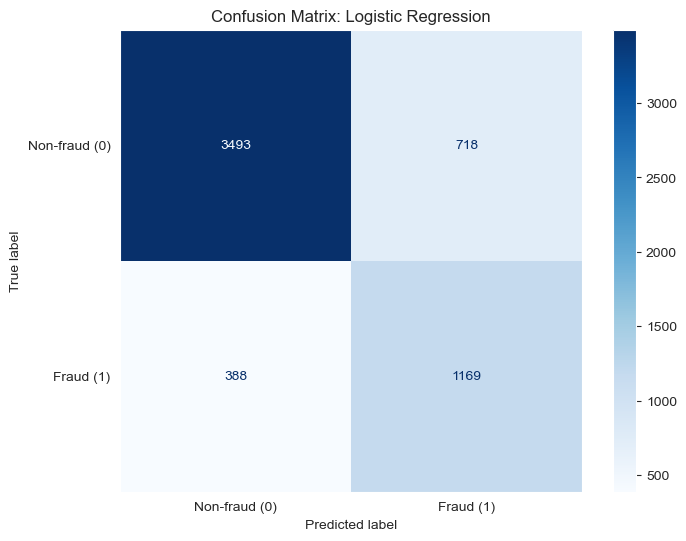

In [35]:
# 4. Generate the Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-fraud (0)', 'Fraud (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Logistic Regression')
plt.grid(False)
plt.show()

| Quadrant | Result | Count | Business Context                                    |
| :--- | :--- | :--- |:----------------------------------------------------|
| **True Negative** | **3493** | Correctly identified as **Legitimate**. | No investigation needed.                            |
| **True Positive** | **1169** | Correctly identified as **Fraudulent**. | **Success:** Revenue saved through fraud detection. |
| **False Positive** | **718** | Legitimate claims incorrectly flagged. | Administrative cost of unnecessary investigation.   |
| **False Negative** | **388** | Fraudulent claims that went undetected. | Financial leakage; claims paid to fraudsters.       |

#### 4.5. Estimating Model-Driven Loss
To evaluate the viability of the model, the predictive performance was translated into a financial impact study. This ensures the model aligns with the client’s goal of balancing fraud detection with customer retention.

* **Market Inference:** A 10% claim rate is assumed to estimate the total customer base from the known claim data. This allows for the calculation of the total potential market size.
* **The 2x Profit Rule:** To ensure operational sustainability and cover overhead, the business model aims for a gross profit equal to double the total expected fraud value.
* **The Churn Penalty:** In accordance with the client's requirements, a **False Positive (FP)** result is assumed to lead to the immediate loss of that customer. The cost is calculated as the loss of the **Price per Policy** (Annual Premium).

| Prediction Type | Business Effect | Financial Result |
| :--- | :--- | :--- |
| **True Positive (TP)** | Fraud identified and stopped. | **Save:** $Average\ Claim$ |
| **False Negative (FN)** | Fraud missed and paid out. | **Lose:** $Average\ Claim$ |
| **False Positive (FP)** | Genuine customer lost to churn. | **Lose:** $Price\ per\ Policy$ |
| **True Negative (TN)** | Correctly ignored legitimate claim. | **No Financial Change** |

Final calculation will be determined by the following formula:

$$Net\ Impact = Savings(TP) - [Cost(FN) + Cost(FP)]$$

In [48]:
# The Average Claim
avg_claim = data_merged['AmountOfTotalClaim'].mean()

# Market size
total_customers = len(data_merged) / 0.10

# Financials
total_expected_claims = len(data_merged) * avg_claim
total_premiums = 2 * total_expected_claims

# Implied charge per policy (premium)
premium_per_policy = total_premiums / total_customers

print(f"Average Claim: ${avg_claim:,.2f}")
print(f"Implied Annual Premium: ${premium_per_policy:,.2f}")

# Confusion matrix counts
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate the components of the Business Logic formula
savings_from_tp = tp * avg_claim
cost_of_fn = fn * avg_claim
cost_of_fp = fp * premium_per_policy

# Final Net Impact Calculation
net_impact = savings_from_tp - (cost_of_fn + cost_of_fp)

print(f"--- Financial Impact Summary ---")
print(f"True Positives (Fraud Caught): {tp}")
print(f"False Negatives (Fraud Missed): {fn}")
print(f"False Positives (Customers Lost): {fp}")
print(f"---------------------------------")
print(f"Net Financial Benefit: ${net_impact:,.2f}")

if net_impact > 0:
    print("The model is financially viable")
else:
    print("The model is not financially viable")

Average Claim: $52,308.55
Implied Annual Premium: $10,461.71
--- Financial Impact Summary ---
True Positives (Fraud Caught): 1169
False Negatives (Fraud Missed): 388
False Positives (Customers Lost): 718
---------------------------------
Net Financial Benefit: $33,341,466.88
The model is financially viable


#### 4.5 Model Stability: Cross-Validation & Error Rate Analysis

The performance of the Logistic Regression pipeline was validated using a Stratified 5-Fold Cross-Validation to ensure the results are consistent across the entire training set.

| Metric             | Mean Value | Interpretation                                                                       |
|:-------------------| :--- |:-------------------------------------------------------------------------------------|
| **Mean Accuracy**  | **81.31%** | Good classification rate, successfully distinguishing between claim types.           |
| **Mean Recall**    | **75.21%** | The model captures 3 out of every 4 fraudulent claims.                               |
| **Mean F1-Score**  | **68.49%** | Good balance between catching fraud (Recall) and minimizing false alarms. |
| **Mean BER**       | **20.61%** | Average error rate across both classes. This confirms high predictive power.         |
| **Recall Std Dev** | **0.0081** | Low variation under 1% the model is robust and not just lucky                        |


In [49]:
from sklearn.model_selection import cross_validate, StratifiedKFold

# Folding strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-Validation on the pipeline
cv_results = cross_validate(
    pipeline_lr,
    X_train,
    y_train,
    cv=skf,
    # ADDED 'balanced_accuracy' here
    scoring=['accuracy', 'recall', 'precision', 'f1', 'balanced_accuracy'],
    return_train_score=False
)

print(f"--- 5-Fold Cross-Validation Results ---")
print(f"Mean Accuracy:  {cv_results['test_accuracy'].mean():.2%}")
print(f"Mean Recall:    {cv_results['test_recall'].mean():.2%}")
print(f"Mean F1-Score:  {cv_results['test_f1'].mean():.2%}")

# Calculate Balanced Accuracy
mean_bal_acc = cv_results['test_balanced_accuracy'].mean()
mean_ber = 1 - mean_bal_acc
print(f"Mean Balanced Error Rate (BER): {mean_ber:.2%}") # This is your target metric!

print(f"Recall Std Dev: {cv_results['test_recall'].std():.4f}")

--- 5-Fold Cross-Validation Results ---
Mean Accuracy:  81.33%
Mean Recall:    75.18%
Mean F1-Score:  68.51%
Mean Balanced Error Rate (BER): 20.61%
Recall Std Dev: 0.0085


4.6 Model Evaluation & Financial Results

The Logistic Regression model is **financially viable** and ready for deployment based on the following justifications:

* **Requirement Fulfillment:** The model meets the client's requirement for an unbiased system that prioritizes fraud detection while managing customer loss. The use of stratified cross-validation and balanced class weights ensures the results are robust and fair.
* **Economic Justification:** Despite not reaching the 5% BER target, the model delivers a net benefit of over **$33.3M**. The savings generated by True Positives significantly outweigh the combined costs of False Positives and False Negatives.

* **Baseline Success:** This establishes a high-performing baseline for the project. Any subsequent techniques (Technique 2) must aim to improve upon this $33.3M net benefit by further reducing the **20.61% BER**.

In [38]:
from sklearn import set_config

# This tells sklearn to display the diagram
set_config(display='diagram')

# Display your master pipeline
feature_selection_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('cleanser',
                                                                   FunctionTransformer(func=<function treat_negative_as_nan at 0x15f6d32e0>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['InsuredAge', 'CapitalGains',
                                                   'CapitalLoss',
                                                   'CustomerLoyaltyPeriod',
                                                   'Policy_Deductible',
                                                   'PolicyAnnualPremiu...
                                                                                 sparse_output=False))]),
                                                  ['InsuredGender',
                                                   'InsuredEducationLevel',
                                                   'InsuredOccupation',
                                                   'InsuredHobbies',
                                                   'InsurancePolicyState',
                                                   'Policy_CombinedSingleLimit',
                                                   'InsuredRelationship',
                                                   'TypeOfIncident',
                                                   'TypeOfCollission',
                                                   'SeverityOfIncident',
                                                   'AuthoritiesContacted',
                                                   'IncidentState',
                                                   'IncidentCity',
                                                   'PropertyDamage',
                                                   'PoliceReport',
                                                   'VehicleMake'])])),
                ('selector', SelectKBest(k=20))])

### Setting hyperparameters (rationale)

A GridSearchCV was used to evaluate 8 hyperparameter candidates across 40 iterations. The optimal configuration identified a strong regularization strength (C=0.01). This choice of a low $C$ value indicates that the model benefits from a 'conservative' fit, which prevents over-reliance on individual high-magnitude features and contributes to the high stability (low standard deviation) observed during validation.

In [39]:
from sklearn.model_selection import GridSearchCV

# 1. Define the parameter grid
# 'classifier__' refers to the name we gave the LogisticRegression in the pipeline
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# 2. Setup the Grid Search
# We use 'f1' or 'recall' as the scoring metric because fraud is imbalanced
grid_search = GridSearchCV(
    pipeline_lr,
    param_grid,
    cv=skf,
    scoring='f1',
    verbose=1
)

# 3. Fit it
grid_search.fit(X_train, y_train)

# 4. Extract results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {grid_search.best_score_:.2%}")

# Use the best model for final evaluation
pipeline_lr = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best Cross-Validation F1-Score: 68.51%


## 5. Technique 2 - Random Forest
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

In [40]:
from sklearn.ensemble import RandomForestClassifier

# 1. Define the Technique 2 Pipeline
pipeline_rf = Pipeline(steps=[
    ('prep_and_sel', feature_selection_pipeline),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced_subsample',
        random_state=42
    ))
])

# 2. TRAINING
pipeline_rf.fit(X_train, y_train)

print("Technique 2: Random Forest Pipeline trained.")

Technique 2: Random Forest Pipeline trained.


In [41]:
# Define parameters to tune
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5]
}

# Run the grid search
grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=skf,
    scoring='balanced_accuracy', # Focuses directly on reducing BER
    verbose=1
)

grid_search_rf.fit(X_train, y_train)
pipeline_rf = grid_search_rf.best_estimator_

print(f"Best RF Parameters: {grid_search_rf.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [50]:
from sklearn.metrics import balanced_accuracy_score
y_pred_rf = pipeline_rf.predict(X_test)
bal_acc_rf = balanced_accuracy_score(y_test, y_pred_rf)
ber_rf = 1 - bal_acc_rf

print(f"Technique 2 BER: {ber_rf:.2%}")

Technique 2 BER: 18.44%


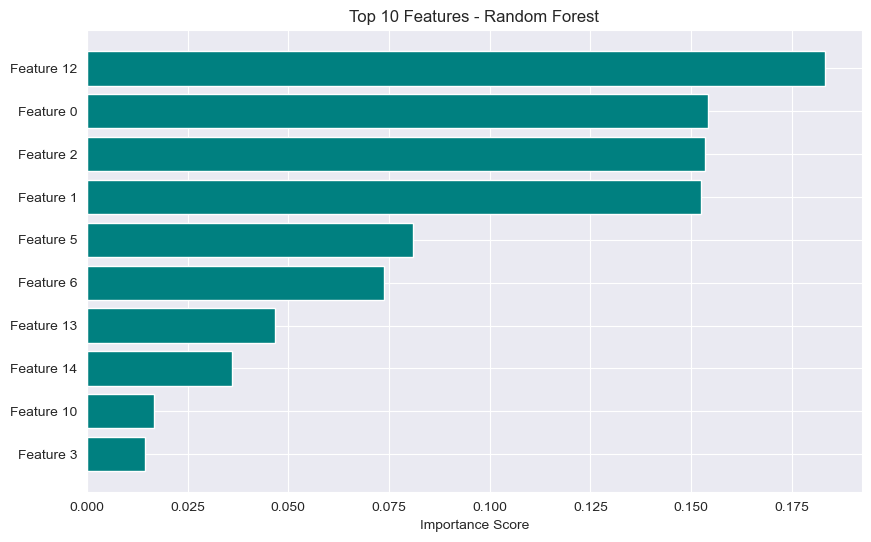

In [43]:
# 1. Get the importances from the RF classifier
importances = pipeline_rf.steps[-1][1].feature_importances_

# 2. Get the feature names from the PREPROCESSOR specifically
# We dig into the feature_selection_pipeline to find the ColumnTransformer
# Assuming your preprocessor is the first part of your feature_selection_pipeline:
preprocessor = pipeline_rf.steps[0][1]

# If the error persists with get_feature_names_out, we can use the names
# from the features we sent into the model:
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback: manually reconstruct names if custom steps broke the metadata
    # This takes the column names from the X_train dataframe after your filtering
    feature_names = X_train.columns

# 3. Create the DataFrame
# Ensure the lengths match (sometimes custom steps drop columns)
if len(feature_names) != len(importances):
    # This is a safety catch to avoid a shape mismatch error
    feature_names = [f"Feature {i}" for i in range(len(importances))]

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# 4. Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel("Importance Score")
plt.title("Top 10 Features - Random Forest")
plt.gca().invert_yaxis()
plt.show()

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 6. Comparison of metrics performance for testing

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Use of nested cross-validation for both techniques to deal with overfitting model selection and model comparison
- Use appropriate metrics for the testing set
- Use an appropriate model selection visualisation curve (ROC, PR, etc.) that is suitable for the problem at hand
- Checking for overfitting

## 7. Final recommendation of the best model

**Create a new subheading for each item you discuss from the following items.**

- Technical perspective- overfitting discussion, complexity and efficiency
- Business perspective- results interpretation, relevance and balance with a technical perspective

## 8. Conclusion

**Create a new subheading for each item you discuss from the following items.**

- What has been successfully accomplished and what has not
- Reflect back on the analysis and see what you could have done differently if you were to do the project again
- Add a wish list of future work that you would do to take the project forward


In [44]:
import json

def count_words(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)

    markdown_word_count = 0
    code_word_count = 0

    for cell in data['cells']:
        # Extract the text content from the cell
        content = "".join(cell['source'])
        words = content.split()

        if cell['cell_type'] == 'markdown':
            markdown_word_count += len(words)
        elif cell['cell_type'] == 'code':
            code_word_count += len(words)

    print(f"--- Notebook Word Count: {filepath} ---")
    print(f"Markdown Words (Report text): {markdown_word_count}")
    print(f"Code Words (Scripts/Variables): {code_word_count}")
    print(f"Total Words: {markdown_word_count + code_word_count}")

# Make sure to save your notebook (Ctrl+S) before running this!
count_words('Assessment.ipynb')

--- Notebook Word Count: Assessment.ipynb ---
Markdown Words (Report text): 2880
Code Words (Scripts/Variables): 1669
Total Words: 4549
